Topic: Project 2    
Subject: EDA   
Date: 10/06/2017  
Name: Zach Heick

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core import datetools

%matplotlib inline

/Users/zacharyheick/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


In [2]:
df = pd.read_pickle('roger_final.pickle')

I first clean up some of the titles to be more consistent.

In [3]:
df.drop(['imdbId'], axis=1, inplace=True)
df.rename(columns={'rating':'MovieLens_Score', 'Imdb_Ratings':'Imdb_Score'}, inplace=True)
df.reset_index(inplace=True, drop=True)
df['Imdb_Score'] = df['Imdb_Score'].astype('float')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4749 entries, 0 to 4748
Data columns (total 9 columns):
Title              4749 non-null object
Year               4749 non-null int64
Star_Score         4749 non-null float64
Genre              4749 non-null object
Sub-genre          4749 non-null object
Rating             4749 non-null object
Runtime            4749 non-null float64
MovieLens_Score    4749 non-null float64
Imdb_Score         4749 non-null float64
dtypes: float64(4), int64(1), object(4)
memory usage: 334.0+ KB


I shuffle the dataframe since Ebert's reviews where descending in order by year. I want to see how his star scores are distributed.

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

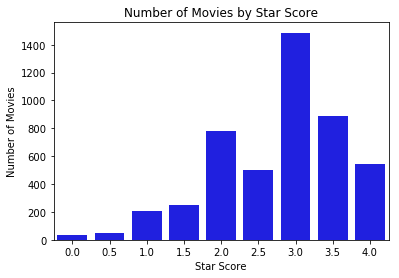

In [6]:
star_score_df = df.groupby(['Star_Score']).agg('count')
fig = sns.barplot(star_score_df.index, star_score_df['Year'], color='b')
fig.set_title('Number of Movies by Star Score')
fig.set(xlabel='Star Score', ylabel='Number of Movies');

I chose to start off with a single feature and will eventually build my model from there. I wanted to see if there was any correlation between Ebert's scores and the scores of IMDb and MovieLens users. There was not a strong correlation between either, but it was a good place to start.

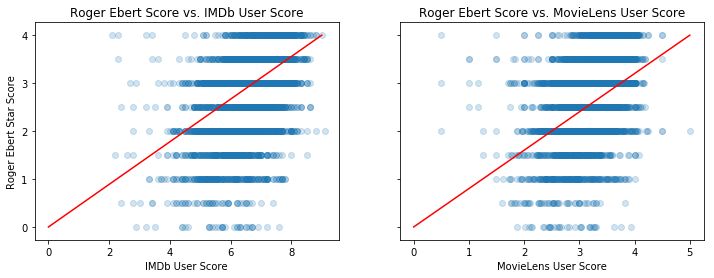

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
ax1.scatter(df['Imdb_Score'], df['Star_Score'], alpha=0.2)
ax1.set_ylabel('Roger Ebert Star Score')
ax1.set_xlabel('IMDb User Score')
ax1.set_title('Roger Ebert Score vs. IMDb User Score')
ax1.plot([0,9], [0,4], 'r')
ax2.scatter(df['MovieLens_Score'], df['Star_Score'], alpha=0.2)
ax2.set_xlabel('MovieLens User Score')
ax2.plot([0,5], [0,4], 'r')
ax2.set_title('Roger Ebert Score vs. MovieLens User Score');

I plot the other features in a pairplot to see if there were any correlations with `Star_Score`, but there were no strong correlations or obvious ways to reengineer any features. 

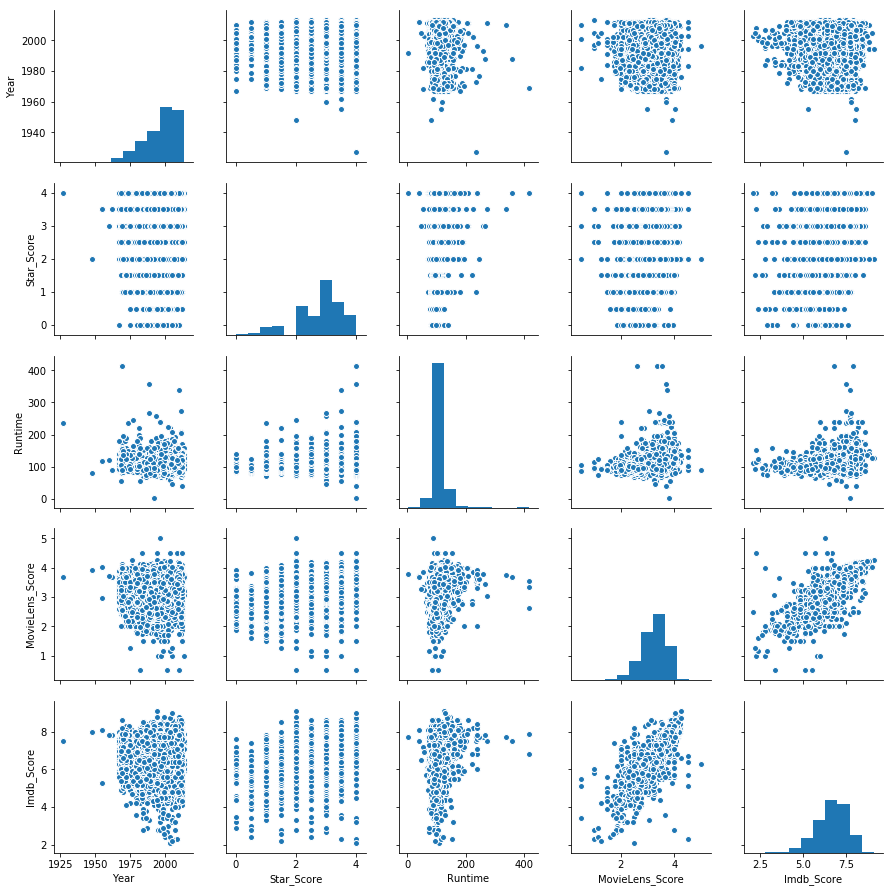

In [8]:
g = sns.pairplot(df)

Some of my features were categorical. To prepare my dataframe for modeling, I need to "dummy" these features. Features with multiple categories have their categories assigned as individual columns. A boolean value of 0 or 1 is used to indicate if a row fell into some category. I remove the `Title` column and the dataframe now only has numeric values.

In [9]:
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre', drop_first=True)
sub_genre_dummies = pd.get_dummies(df['Sub-genre'], prefix='Sub_Genre', drop_first=True)
rating_dummies = pd.get_dummies(df['Rating'], prefix='Rating', drop_first=True)

df = df.join(genre_dummies).join(sub_genre_dummies).join(rating_dummies)
df.drop(['Title', 'Genre', 'Sub-genre', 'Rating'], inplace=True, axis=1)
df.head()

,Year,Star_Score,Runtime,MovieLens_Score,Imdb_Score,Genre_Adventure,Genre_Animation,Genre_Comedy,Genre_Crime,Genre_Disaster,...,Sub_Genre_Thriller,Sub_Genre_War,Sub_Genre_Western,Rating_NC-17,Rating_NR,Rating_PG,Rating_PG-13,Rating_R,Rating_Unrated,Rating_X
0,2012,4.0,105.0,3.125000,5.7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1984,3.0,128.0,2.997386,5.9,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2012,2.0,104.0,3.225352,6.2,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,1992,3.0,91.0,3.756345,7.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2002,3.0,138.0,3.219805,6.7,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Because of the difficulty finding correlations to `Star_Score` when looking at the pairplot, I look at the correlation scores to get a better understanding.

In [10]:
df.corr()['Star_Score'].sort_values(ascending=False)[:30]

Star_Score                1.000000
Imdb_Score                0.473117
MovieLens_Score           0.463274
Genre_Drama               0.190089
Runtime                   0.180758
Sub_Genre_Foreign         0.132184
Genre_Documentary         0.112628
Rating_NR                 0.103017
Sub_Genre_History         0.064742
Sub_Genre_Indie           0.061483
Sub_Genre_Drama           0.061381
Year                      0.060672
Genre_Crime               0.047732
Sub_Genre_Animation       0.031895
Rating_Unrated            0.030174
Rating_R                  0.029745
Genre_Music               0.028882
Sub_Genre_Disaster        0.028804
Genre_Animation           0.028237
Sub_Genre_Musical         0.026326
Sub_Genre_Music           0.024916
Sub_Genre_War             0.022913
Sub_Genre_Erotic          0.021320
Genre_Disaster            0.020827
Sub_Genre_Documentary     0.019610
Genre_Thriller            0.016465
Sub_Genre_Eastern         0.016097
Sub_Genre_Sports Film     0.011504
Sub_Genre_No Sub-gen

In [11]:
df.corr()['Star_Score'].sort_values()[:15]

Sub_Genre_Comedy            -0.121130
Rating_PG-13                -0.094903
Genre_Comedy                -0.081085
Genre_Horror                -0.073149
Sub_Genre_Horror            -0.068630
Sub_Genre_Romance           -0.057994
Genre_Foreign               -0.049339
Rating_NC-17                -0.048292
Sub_Genre_Fantasy           -0.039330
Rating_PG                   -0.038057
Sub_Genre_Family            -0.030475
Sub_Genre_Thriller          -0.029576
Sub_Genre_Science Fiction   -0.025432
Genre_Science Fiction       -0.024975
Genre_Romance               -0.024774
Name: Star_Score, dtype: float64

Having a better idea of what's going on in the data, I am now ready to start building a model.

In [12]:
df.to_pickle('roger_final_model_ready.pickle')